In [1]:
reset -f

In [95]:
from collections import Counter
import calendar
from datetime import date
import warnings
import holidays
import numpy as np
import scipy
import fbprophet
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

## Crowdedness at the Gym Dataset
### - The data collects the number of headcount and temperature in the Gym for every 10 mins.

## 1. Load Data

In [3]:
df = pd.read_csv('data/data.csv', low_memory=False)

In [4]:
df.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


In [5]:
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
number_people           62184 non-null int64
date                    62184 non-null object
timestamp               62184 non-null int64
day_of_week             62184 non-null int64
is_weekend              62184 non-null int64
is_holiday              62184 non-null int64
temperature             62184 non-null float64
is_start_of_semester    62184 non-null int64
is_during_semester      62184 non-null int64
month                   62184 non-null int64
hour                    62184 non-null int64
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [7]:
# For some reason, the timestamp is not correct, therefor it will be removed from the dataset
del df['timestamp']

In [8]:
df['date'] = df['date'].apply(lambda s:pd.Timestamp(s[:16]))
df = df.set_index('date')

In [9]:
# The is_holiday columns are incorrect, thus manually recreate this column
us_holidays = holidays.US()
df.is_holiday = [x in us_holidays for x in df.index.date]

In [10]:
df_clean = df.resample('1h').max().fillna(0)
df_clean = df_clean[7:3800]
df_clean.head()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
date,,,,,,,,,
2015-08-15 00:00:00,1.0,5.0,1.0,0.0,66.76,0.0,0.0,8.0,0.0
2015-08-15 01:00:00,0.0,5.0,1.0,0.0,66.32,0.0,0.0,8.0,1.0
2015-08-15 02:00:00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2015-08-15 03:00:00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2015-08-15 04:00:00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [11]:
print('The data starts from %s to %s'%(df_clean.index.min(),df_clean.index.max()))

The data starts from 2015-08-15 00:00:00 to 2016-01-20 00:00:00


## 2. EDA

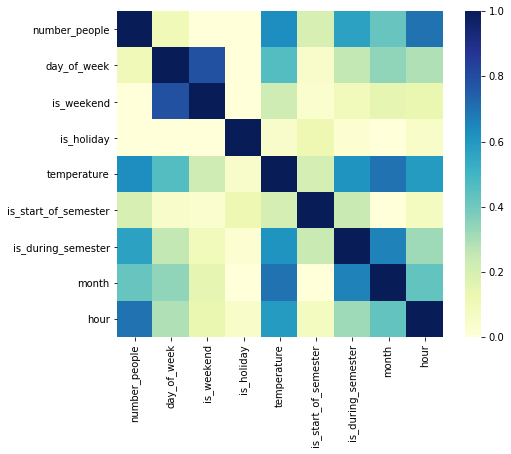

In [12]:
corr = df_clean.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,square=True,vmin=0,cmap="YlGnBu");

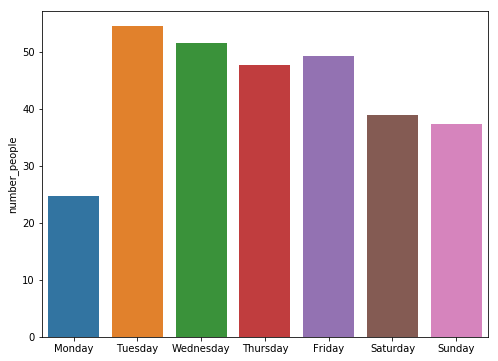

In [13]:
group_weekday = df_clean.groupby(['day_of_week']).mean()
plt.figure(figsize=(8,6))
# make a plot of the avg number of people for each day of the week. 
# The purpose here is to directly visualize the crowdedness for different weekday.  
ax = sns.barplot(data=group_weekday, x=list(calendar.day_name), 
                 y=group_weekday['number_people']);

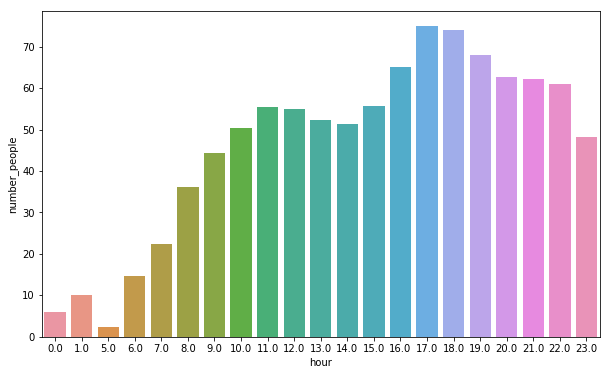

In [14]:
group_hour = df_clean.groupby(['hour']).mean()
plt.figure(figsize=(10,6))
# make a plot of the avg number of people for each day of the week. 
# The purpose here is to directly visualize the crowdedness for different weekday.  
ax = sns.barplot(data=group_hour, x=group_hour.index, 
                 y=group_hour['number_people']);

## 3. Timeseries Analysis

In [15]:
series = df_clean['number_people'][:3000]
series_test = df_clean['number_people'][3001:]

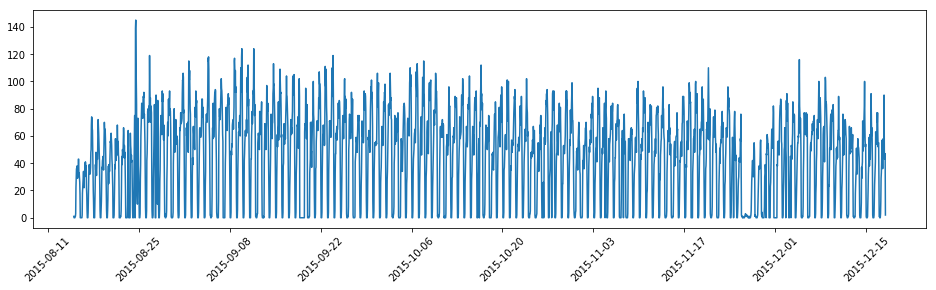

In [16]:
plt.figure(figsize=(16,4))
plt.plot(series)
plt.xticks(rotation=45)
plt.show();

In [17]:
decompos = sm.tsa.seasonal_decompose(series)

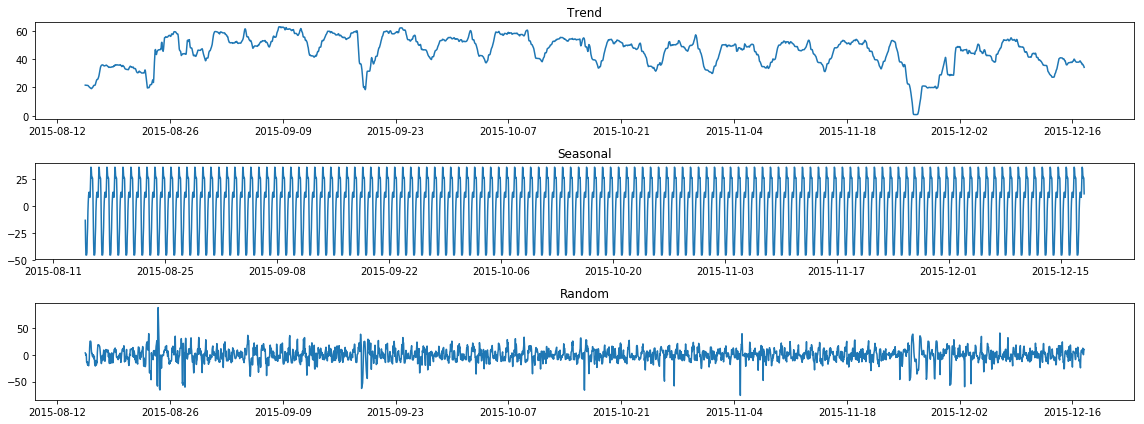

In [18]:
fig, axs = plt.subplots(3, figsize=(16,6))
axs[0].plot(decompos.trend)
axs[0].set_title('Trend')
axs[1].plot(decompos.seasonal)
axs[1].set_title('Seasonal')
axs[2].plot(decompos.resid)
axs[2].set_title('Random')
plt.tight_layout();

### Check for Stationarity

In [19]:
roll_mean = series.rolling(50, min_periods=1).mean()
roll_std = series.rolling(50, min_periods=1).std()

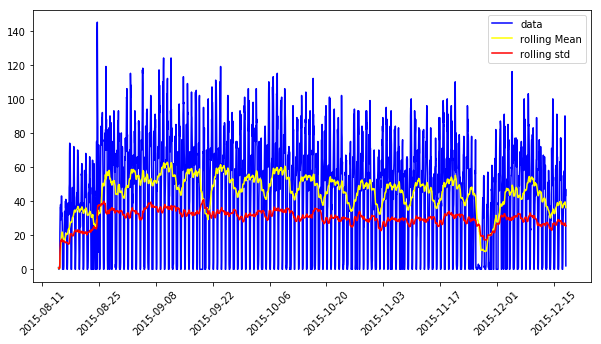

In [20]:
plt.figure(figsize=(10,5))
plt.plot(series, color='blue', label='data')
plt.plot(roll_mean, color='yellow', label='rolling Mean')
plt.plot(roll_std, color='red', label='rolling std')
plt.legend(loc='best');
plt.xticks(rotation=45)
plt.show();

In [26]:
def station_check(x, th=0.01):
    p_value = sm.tsa.adfuller(x)[1]
    if p_value < th:
        return round(p_value, 3)
    else:
        return False

In [27]:
station_check(series)

0.0

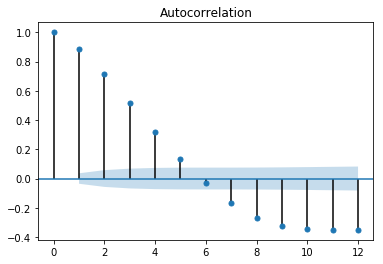

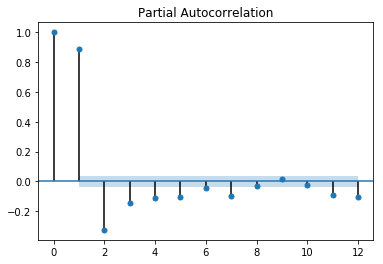

In [28]:
sm.graphics.tsa.plot_acf(series, lags=12)
sm.graphics.tsa.plot_pacf(series, lags=12)
plt.show()

### Modeling

In [98]:
model = ARIMA(series, order=(2,1,0))
model_fit = model.fit(disp=0)

In [84]:
history = [x for x in series]
predictions = []
for t in range(len(series_test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = series_test[t]
    history.append(obs)
error = sqrt(mean_squared_error(series_test, predictions))
print('Test RMSE: %.3f' % error)

Test RMSE: 8.816


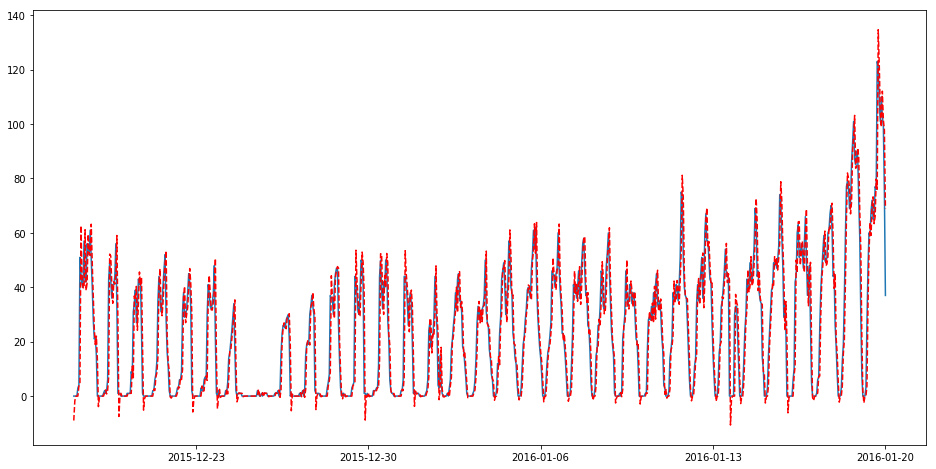

In [82]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(series_test)
plt.plot(pd.Series(predictions,index=series_test.index), 'r--');
plt.show()

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
df_dummie = pd.get_dummies(df_clean, columns=['is_weekend', 'is_holiday', 'is_start_of_semester', 'is_during_semester', 'day_of_week', 'month', 'hour'])

In [46]:
df_dummie.head()

,number_people,temperature,is_weekend_0.0,is_weekend_1.0,is_holiday_0.0,is_holiday_1.0,is_start_of_semester_0.0,is_start_of_semester_1.0,is_during_semester_0.0,is_during_semester_1.0,...,hour_14.0,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0
date,,,,,,,,,,,,,,,,,,,,,
2015-08-15 00:00:00,1.0,66.76,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-08-15 01:00:00,0.0,66.32,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-08-15 02:00:00,0.0,0.00,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-08-15 03:00:00,0.0,0.00,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-08-15 04:00:00,0.0,0.00,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
train = df_dummie.iloc[:3000, 1:]
test = df_dummie.iloc[3001:, 1:]
y_train = df_dummie.iloc[:3000, 0]
y_test = df_dummie.iloc[3001:, 0]

In [52]:
rf = RandomForestRegressor(random_state=42,  
                             n_estimators=30,
                             max_depth=40, 
                             min_samples_split=3, 
                             min_samples_leaf=2, 
                             bootstrap=True)

In [53]:
rf.fit(train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
predictions = rf.predict(test)

In [55]:
error = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % error)

Test RMSE: 17.810
